In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torch.utils.data as data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import deeptriplet
from deeptriplet.datasets import PascalDataset

In [18]:
dvgg = deeptriplet.models.DeepLab_VGG(n_classes=30, version="aspp-l")
dvgg = dvgg.eval()

In [5]:
d = torch.load("/srv/glusterfs/yardima/runs/deeplabv2/lfov/run_5/models/class-vgg-pascal_epoch-29.pth")

In [5]:
d = torch.load("/srv/glusterfs/yardima/runs/deeplabv2/asppl/run_0/models/class-vgg-asppl-pascal_epoch-19.pth")

In [7]:
del d['aspp_branches.3.2.weight']
del d['aspp_branches.3.2.bias']

del d['aspp_branches.2.2.weight']
del d['aspp_branches.2.2.bias']

del d['aspp_branches.1.2.weight']
del d['aspp_branches.1.2.bias']

del d['aspp_branches.0.2.weight']
del d['aspp_branches.0.2.bias']

In [8]:
dvgg.load_state_dict(d, strict=False)
dvgg = dvgg.eval().cuda()

In [9]:
trainset = PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

In [10]:
i, l = next(iter(trainloader))

In [ ]:
trainset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


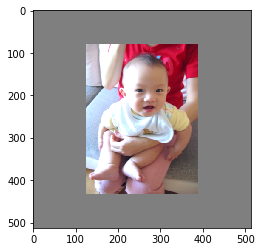

In [11]:
plt.imshow(np.transpose(i[7].numpy(), axes=[1, 2, 0]) / 4 + 0.5)

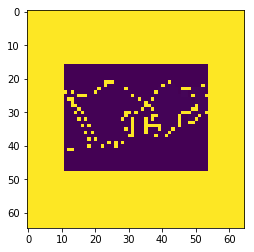

In [17]:
plt.imshow(l[5])

In [13]:
a = np.random.rand(5,5)
print(a)

[[0.63029306 0.6460845  0.94723077 0.27364272 0.72573436]
 [0.45348846 0.4309979  0.66929653 0.60624004 0.52203477]
 [0.55001381 0.90685658 0.0813915  0.83612443 0.6213364 ]
 [0.20473043 0.78112632 0.44614621 0.83341428 0.60702142]
 [0.04678119 0.73245477 0.5524684  0.13585063 0.60056724]]


In [14]:
a[(1,2),(2,3)]

array([0.66929653, 0.83612443])

In [48]:
np.nonzero(np.array([0,1,1,0]))

(array([1, 2]),)

In [9]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
import random

from torch.utils import data
from torchvision import transforms

def read_labeled_image_list(data_dir, data_list):
    """Reads txt file containing paths to images and ground truth masks.

    Args:
      data_dir: path to the directory with images and masks.
      data_list: path to the file with lines of the form '/path/to/image /path/to/mask'.

    Returns:
      Two lists with all file names for images and masks, respectively.
    """
    f = open(data_list, 'r')
    images = []
    masks = []
    for line in f:
        image, mask = line.strip("\n").split(' ')
        images.append(data_dir + image)
        masks.append(data_dir + mask)

    return images, masks

class PascalDatasetRandomTriplet(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.
    """

    def __init__(
            self,
            *,
            pascal_root,
            split_file,
            n_triplets,
            normalize_imagenet=False,
            augment=False,
            pad_zeros=False,
            downsample_label=1,
            scale_low=0.6,
            scale_high=1.4
    ):
        self.split_file = split_file
        self.pascal_root = pascal_root
        self.n_triplets = n_triplets

        self.scale_low = scale_low
        self.scale_high = scale_high

        self.normalize_imagenet = normalize_imagenet

        self.downsample_label = downsample_label

        self.augment = augment
        self.pad_zeros = pad_zeros

        self.n_classes = 21

        self.image_list, self.label_list = read_labeled_image_list(self.pascal_root, self.split_file)

        if self.normalize_imagenet:
            self.transforms = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])])
        else:
            self.transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):
        im_path = self.image_list[index]
        lbl_path = self.label_list[index]

        img = PIL.Image.open(im_path)
        lbl = PIL.Image.open(lbl_path)

        ## augmentation
        if self.augment:
            img, lbl = self._augment(img, lbl)
        elif self.downsample_label > 1:
            lbl = lbl.resize((math.ceil(lbl.width / self.downsample_label),
                              math.ceil(lbl.height / self.downsample_label)))

        img = np.array(img, dtype=np.float32) / 255.0
        lbl = np.array(lbl, dtype=np.long)
        #         lbl[lbl==255] = 0

        minrange = (0,0)
        maxrange = (lbl.shape[0], lbl.shape[1])

        if self.pad_zeros:
            img, lbl, minrange, maxrange = self._pad_zeros(img, lbl)
            
        img = self.transforms(img)
        triplets = self._generate_triplet(lbl, minrange, maxrange)

        return img, triplets

    def _generate_triplet(self, lbl, minrange, maxrange):
        lbl_view = lbl[minrange[0]:maxrange[0], minrange[1]:maxrange[1]]
        
        options = np.nonzero(lbl_view.reshape(-1) != 255)[0]
        ai = np.random.randint(low=0, 
                                high=options.shape[0], 
                                size=(self.n_triplets,))
        ai = options[ai]
        

        classes, inv_map = np.unique(lbl_view, return_inverse=True)
        n_classes = len(classes)
        inv_map = inv_map.reshape(lbl_view.shape[0], lbl_view.shape[1])
        inv_map_flat = inv_map.reshape(-1)

        class_lookup = (np.arange(n_classes, dtype=np.int32).reshape((1, 1, n_classes)) !=
                        inv_map.reshape(lbl_view.shape[0], lbl_view.shape[1], 1))
        class_lookup = np.transpose(class_lookup, axes=[2, 0, 1])
        
        lbl_view_flat = lbl_view.reshape(-1)
        
        lneg = []
        lpos = []
        for i in range(n_classes):
            lneg.append(np.transpose(np.logical_and(lbl_view != 255, class_lookup[i]).reshape(-1).nonzero()).reshape((-1)))
            lpos.append(np.transpose(
                                np.logical_and(lbl_view != 255, 
                                               np.logical_not(class_lookup[i])).reshape(-1).nonzero()).reshape((-1)))

        ni, pi = [], []
        for i in range(self.n_triplets):
            cni = lneg[inv_map_flat[ai[i]]]
            cpi = lpos[inv_map_flat[ai[i]]]
            if len(cni) == 0:
                ni.append(ai[i])
                pi.append(ai[i])
            else:
                ni.append( np.random.choice(cni))
                pi.append( np.random.choice(cpi))
            
        aix, aiy = np.unravel_index(ai, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        aix += minrange[0]
        aiy += minrange[1]
        ai = np.stack((aix, aiy))
        
        pix, piy = np.unravel_index(pi, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        pix += minrange[0]
        piy += minrange[1]
        pi = np.stack((pix, piy))
        
        nix, niy = np.unravel_index(ni, dims=(lbl_view.shape[0], lbl_view.shape[1]))
        nix += minrange[0]
        niy += minrange[1]
        ni = np.stack((nix, niy))
        
        triplets = np.stack((ai, pi, ni), axis=0)
        triplets = torch.tensor(triplets, dtype=torch.long)
    
        return triplets
    
    
    def _augment(self, img, lbl):

        if np.random.rand() > 0.5:
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            lbl = lbl.transpose(PIL.Image.FLIP_LEFT_RIGHT)

        scale = np.random.uniform(low=self.scale_low, high=self.scale_high)
        target_size = (int(round(img.width * scale)),
                       int(round(img.height * scale)))

        img = img.resize(target_size, resample=PIL.Image.BILINEAR)
        lbl = lbl.resize((math.ceil(target_size[0] / self.downsample_label),
                          math.ceil(target_size[1] / self.downsample_label)))

        return img, lbl

    def _pad_zeros(self, img, lbl):

        th, tw = 513, 513
        thl, twl = (math.ceil(513 / self.downsample_label), math.ceil(513 / self.downsample_label))

        h, w = img.shape[0], img.shape[1]

        if w > tw:
            i = random.randint(0, w - tw)
            img = img[:, i:i + tw, :]

            i = round(i / self.downsample_label)
            lbl = lbl[:, i:i + twl]

        if h > th:
            j = random.randint(0, h - th)
            img = img[j:j + th, :, :]

            j = round(j / self.downsample_label)
            lbl = lbl[j:j + thl, :]

        h, w = img.shape[0], img.shape[1]
        hl, wl = lbl.shape[0], lbl.shape[1]

        if self.normalize_imagenet:
            img_padded = np.zeros((th, tw, 3), dtype=np.float32)
            img_padded[:, :, 0] = 0.485
            img_padded[:, :, 1] = 0.456
            img_padded[:, :, 2] = 0.406
        else:
            img_padded = np.zeros((th, tw, 3), dtype=np.float32)

        lbl_padded = np.ones((thl, twl), dtype=np.long) * 255

        start_h = (th - h) // 2
        start_w = (tw - w) // 2

        start_hl = (thl - hl) // 2
        start_wl = (twl - wl) // 2

        img_padded[start_h:start_h+h, start_w:start_w+w, :] = img
        lbl_padded[start_hl:start_hl+hl, start_wl:start_wl+wl] = lbl
        
        minrange = (start_hl, start_wl)                       
        maxrange = (start_hl+hl, start_wl+wl)
                              
        return img_padded, lbl_padded, minrange, maxrange

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb


In [10]:
valset = deeptriplet.datasets.PascalDatasetRandomTriplet(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            n_triplets=200,
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=8)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=False)

trainset = deeptriplet.datasets.PascalDatasetRandomTriplet(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        n_triplets=200,
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

In [7]:
len(valset)

1449

In [17]:
i,t = next(iter(trainloader))

In [18]:
t.shape

torch.Size([10, 3, 2, 100])

In [103]:
%%time
t = trainset[0]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 36.5 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


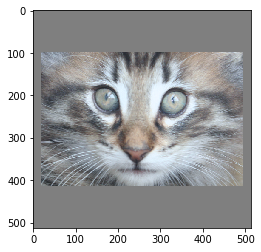

In [79]:
plt.imshow(np.transpose(t[0].numpy(), axes=[1, 2, 0]) / 5 + 0.5)

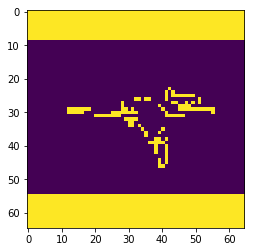

In [59]:
plt.imshow(t[2])

In [28]:
plt.hist(t[2][ai[0], ai[1]].reshape(-1))

NameError: name 't' is not defined

In [29]:

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


class RandomTripletPreselected:

    def __init__(self, n_batch, n_triplets, margin=1, l2_penalty=1e-3):
        self.margin = margin
        self.l2_penalty = l2_penalty
        self.n_triplets =  n_triplets
        self.n_batch = n_batch

        self.loss_fun = nn.MarginRankingLoss(margin=margin)
        self.target = torch.FloatTensor(n_triplets * n_batch).fill_(1).cuda()
        
        i = 0
        self.dim0 = []
        for i in range(self.n_batch):
            self.dim0 += self.n_triplets * [i]
            
        self.dim0 = torch.from_numpy(np.array(self.dim0, dtype=np.long))

    def compute_loss(self, output, triplets):

        if len(self.dim0) != triplets.shape[0] * triplets.shape[3]:
            self.dim0 = []
            for i in range(triplets.shape[0]):
                self.dim0 += triplets.shape[3] * [i]
            
            self.dim0 = torch.from_numpy(np.array(self.dim0, dtype=np.long))
            
            del self.target
            self.target = torch.FloatTensor(triplets.shape[0] * triplets.shape[3]).fill_(1).cuda()
        
        n_dim = output.shape[1]
        
        #output = output.view(n_dim, -1)
        t = triplets
        
        aix = t[:,0,0,:].contiguous().view(-1)
        aiy = t[:,0,1,:].contiguous().view(-1)
        pix = t[:,1,0,:].contiguous().view(-1)
        piy = t[:,1,1,:].contiguous().view(-1)
        nix = t[:,2,0,:].contiguous().view(-1)
        niy = t[:,2,1,:].contiguous().view(-1)
        
        l2_norm = (output[self.dim0, :, aix, aiy].pow(2).sum(dim=1).mean() + 
                    output[self.dim0, :, pix, piy].pow(2).sum(dim=1).mean() + 
                    output[self.dim0, :, nix, niy].pow(2).sum(dim=1).mean())
                
        distp = (output[self.dim0, :, aix, aiy] - output[self.dim0, :, pix, piy]).pow(2).sum(dim=1)
        distn = (output[self.dim0, :, aix, aiy] - output[self.dim0, :, nix, niy]).pow(2).sum(dim=1)

        loss = self.loss_fun(distn, distp, self.target) + l2_norm * self.l2_penalty

        return loss




In [12]:
import deeptriplet.triplet

In [13]:
rt = deeptriplet.triplet.RandomTripletPreselected(n_batch=10, n_triplets=200)

In [21]:
i,t = next(iter(trainloader))
i = i.cuda()

In [22]:
out = dvgg(i)

In [23]:
%%time
tloss = rt.compute_loss(out, t)

CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 185 ms


In [24]:
%%time
tloss.backward()

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 20.2 ms


In [14]:
init_lr = 3e-3

optimizer = optim.SGD([
                {'params': dvgg.get_parameter_group_v2(bias=False, final=False), 'lr': init_lr},
                {'params': dvgg.get_parameter_group_v2(bias=True, final=False), 'lr': init_lr*2, 'weight_decay':0},
                {'params': dvgg.get_parameter_group_v2(bias=False, final=True), 'lr': init_lr*10},
                {'params': dvgg.get_parameter_group_v2(bias=True, final=True), 'lr': init_lr*20, 'weight_decay':0}
            ], lr=init_lr, momentum=0.9, weight_decay = 5e-4)

In [15]:
def update_lr_poly(optimizer, init_lr, step, max_step, power):
    lr = init_lr * ( (1-step/float(max_step)) ** (power))
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = 2*lr
    optimizer.param_groups[2]['lr'] = 10*lr
    optimizer.param_groups[3]['lr'] = 20*lr
    
    return optimizer

In [16]:
%%time
max_epochs = 20
max_steps = max_epochs * (len(trainset) // 10)
dvgg = dvgg.eval()

step = 0

for epoch in range(1):
    for imgs, lbls in trainloader:
        imgs = imgs.cuda()
        lbls = lbls.cuda()

        optimizer = update_lr_poly(optimizer, init_lr, step, max_steps, 0.9)

        optimizer.zero_grad()

        out = dvgg(imgs)

        loss = rt.compute_loss(out, lbls)
        loss.backward()

        optimizer.step()

        print("Step {}, loss: {}".format(step, loss.item()))

        del loss, out
            
        step += 1


Step 0, loss: 0.5165858268737793
Step 1, loss: 0.4433770179748535
Step 2, loss: 0.3951658010482788
Step 3, loss: 0.42341482639312744
Step 4, loss: 0.3722645938396454
Step 5, loss: 0.3789924383163452
Step 6, loss: 0.3947300612926483
Step 7, loss: 0.31620508432388306
Step 8, loss: 0.484781950712204
Step 9, loss: 0.4274158477783203
Step 10, loss: 0.2862088084220886
Step 11, loss: 0.2976928949356079
Step 12, loss: 0.2732146680355072
Step 13, loss: 0.318126916885376
Step 14, loss: 0.3370911180973053
Step 15, loss: 0.3908052146434784
Step 16, loss: 0.387886643409729
Step 17, loss: 0.3952626585960388
Step 18, loss: 0.40021684765815735
Step 19, loss: 0.36959317326545715
Step 20, loss: 0.41349154710769653
Step 21, loss: 0.3051055073738098
Step 22, loss: 0.4579228162765503
Step 23, loss: 0.2997870147228241
Step 24, loss: 0.27820447087287903
Step 25, loss: 0.2588691711425781
Step 26, loss: 0.22315190732479095
Step 27, loss: 0.34815514087677
Step 28, loss: 0.2715127468109131
Step 29, loss: 0.24345

Step 235, loss: 0.3428536653518677
Step 236, loss: 0.20584595203399658
Step 237, loss: 0.25232383608818054
Step 238, loss: 0.19932256639003754
Step 239, loss: 0.21947628259658813
Step 240, loss: 0.23631665110588074
Step 241, loss: 0.20478767156600952
Step 242, loss: 0.33446818590164185
Step 243, loss: 0.29498642683029175
Step 244, loss: 0.1604471057653427
Step 245, loss: 0.25327378511428833
Step 246, loss: 0.2151232212781906
Step 247, loss: 0.16934406757354736
Step 248, loss: 0.2792988717556
Step 249, loss: 0.23755265772342682
Step 250, loss: 0.27924075722694397
Step 251, loss: 0.20136389136314392
Step 252, loss: 0.16790223121643066
Step 253, loss: 0.24831998348236084
Step 254, loss: 0.3243211507797241
Step 255, loss: 0.4160781800746918
Step 256, loss: 0.23778469860553741
Step 257, loss: 0.30508241057395935
Step 258, loss: 0.27467435598373413
Step 259, loss: 0.3141576051712036
Step 260, loss: 0.26372188329696655
Step 261, loss: 0.32210826873779297
Step 262, loss: 0.2588009238243103
Ste

Step 465, loss: 0.23294678330421448
Step 466, loss: 0.25031745433807373
Step 467, loss: 0.3543843626976013
Step 468, loss: 0.2110660821199417
Step 469, loss: 0.2509003281593323
Step 470, loss: 0.23427541553974152
Step 471, loss: 0.22706788778305054
Step 472, loss: 0.2239629626274109
Step 473, loss: 0.329411119222641
Step 474, loss: 0.29785990715026855
Step 475, loss: 0.14667034149169922
Step 476, loss: 0.22186046838760376
Step 477, loss: 0.18122975528240204
Step 478, loss: 0.25522884726524353
Step 479, loss: 0.21040181815624237
Step 480, loss: 0.2569692134857178
Step 481, loss: 0.19606292247772217
Step 482, loss: 0.2344326227903366
Step 483, loss: 0.17512205243110657
Step 484, loss: 0.1578710824251175
Step 485, loss: 0.288851261138916
Step 486, loss: 0.2061762660741806
Step 487, loss: 0.3233933448791504
Step 488, loss: 0.16788189113140106
Step 489, loss: 0.2757830023765564
Step 490, loss: 0.19716843962669373
Step 491, loss: 0.2337820678949356
Step 492, loss: 0.16641105711460114
Step 49

Step 696, loss: 0.20463337004184723
Step 697, loss: 0.1717734932899475
Step 698, loss: 0.3182860016822815
Step 699, loss: 0.17043842375278473
Step 700, loss: 0.28645262122154236
Step 701, loss: 0.24207504093647003
Step 702, loss: 0.2156917005777359
Step 703, loss: 0.21816010773181915
Step 704, loss: 0.22767218947410583
Step 705, loss: 0.1954723745584488
Step 706, loss: 0.166885107755661
Step 707, loss: 0.24858476221561432
Step 708, loss: 0.16174711287021637
Step 709, loss: 0.2857327461242676
Step 710, loss: 0.21463844180107117
Step 711, loss: 0.18531686067581177
Step 712, loss: 0.2191523015499115
Step 713, loss: 0.25488758087158203
Step 714, loss: 0.2489185780286789
Step 715, loss: 0.2159469723701477
Step 716, loss: 0.12457918375730515
Step 717, loss: 0.16339516639709473
Step 718, loss: 0.13966935873031616
Step 719, loss: 0.25975826382637024
Step 720, loss: 0.1879296898841858
Step 721, loss: 0.17253415286540985
Step 722, loss: 0.22068461775779724
Step 723, loss: 0.22075974941253662
Ste

Step 926, loss: 0.17096476256847382
Step 927, loss: 0.21381829679012299
Step 928, loss: 0.18788321316242218
Step 929, loss: 0.21953099966049194
Step 930, loss: 0.16594772040843964
Step 931, loss: 0.18289989233016968
Step 932, loss: 0.17647364735603333
Step 933, loss: 0.24023957550525665
Step 934, loss: 0.23710213601589203
Step 935, loss: 0.2614666819572449
Step 936, loss: 0.19988709688186646
Step 937, loss: 0.24860726296901703
Step 938, loss: 0.21770894527435303
Step 939, loss: 0.1964622288942337
Step 940, loss: 0.2075745314359665
Step 941, loss: 0.23992453515529633
Step 942, loss: 0.1969406008720398
Step 943, loss: 0.20434224605560303
Step 944, loss: 0.1692449301481247
Step 945, loss: 0.22287648916244507
Step 946, loss: 0.2591206431388855
Step 947, loss: 0.20855294167995453
Step 948, loss: 0.19765610992908478
Step 949, loss: 0.2516244053840637
Step 950, loss: 0.2557465732097626
Step 951, loss: 0.2324303388595581
Step 952, loss: 0.18180187046527863
Step 953, loss: 0.15149801969528198
S

In [31]:
net = dvgg
loss_fn = rt

In [32]:
count_val = 0
loss_val = 0.0
with torch.no_grad():
    for ii, sample_batched in enumerate(valloader):
        inputs, labels = sample_batched
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = net.forward(inputs)
        loss = loss_fn.compute_loss(outputs, labels)

        loss_val += loss.item()

        del outputs, loss

        count_val += 1

loss_val /= count_val

print(loss_val)

0.6906352829602029


In [24]:
trainset[5810]

TypeError: 'DataLoader' object does not support indexing

In [ ]:
tra

In [25]:
i = 0
for imgs, lbls in trainloader:
    
    
    if i == 581:
        break
    
    i+=1
    

ValueError: Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-10-7b4ad14c6573>", line 102, in __getitem__
    triplets = self._generate_triplet(lbl, minrange, maxrange)
  File "<ipython-input-10-7b4ad14c6573>", line 137, in _generate_triplet
    ni.append( np.random.choice(lneg[inv_map_flat[ai[i]]]))
  File "mtrand.pyx", line 1126, in mtrand.RandomState.choice
ValueError: a must be non-empty


Process Process-13:
Process Process-15:
Process Process-14:
Process Process-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._

In [28]:
lbls.shape

torch.Size([10, 3, 2, 100])

In [77]:
t = t.cuda()

In [82]:
%%time
aix = t[:,0,0,:].contiguous().view(-1)
aiy = t[:,0,1,:].contiguous().view(-1)
pix = t[:,1,0,:].contiguous().view(-1)
piy = t[:,1,1,:].contiguous().view(-1)
nix = t[:,2,0,:].contiguous().view(-1)
niy = t[:,2,1,:].contiguous().view(-1)

out[rt.dim0, :, aix, aiy].pow(2).sum(dim=1).shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.51 ms


In [29]:
out.shape

torch.Size([10, 32, 65, 65])